# Git workflow for MARBL
Given the scientific nature of the MARBL library, it is not practical to expect users to update to the latest version of the library regularly. This workflow is designed to allow bugfixes to be applied to old releases. There are two main branches: _development_ contains the latest development code, and _stable_ is the latest release.

**REQUIREMENT:** _development_ must be even with our directly ahead of _stable_; a new release will be made by _git checkout stable ; git merge development --ff-only_

When a GCM incorporates a specific version of MARBL, we will make a GCM-specific release branch off of _stable_. Example: the _v0.29.0_ on _development_ will correspond to the _v1.0.0-beta01_ tag on _stable_. This is the version of MARBL to be used in CESM 2.0, so we will also make a _cesm2.0_ branch (and a _cesm2.0-n00_ tag) at this point.

In [1]:
import pydot

# Needed to render pydot graph
# from https://stackoverflow.com/a/36463158
from IPython.display import Image, display
def viewPydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)

# Color choices
development = {"label": "dev", "color": "black"}
stable = {"label": "sta", "color": "lightblue"}
release_branch = {"label": None, "color": "green"}
bugfix_enhancement = {"label": None, "color": "orange"}

## Initial State

To start, we'll think of commit `C0` as "initial release". This exists on three branchs: _development_, _stable_, and _cesm2.0_; it is tagged as _v0.29.0_, _cesm1.0.0-beta01_, and _cesm2.0-n00_.


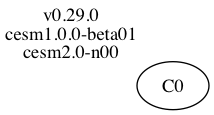

In [2]:
# Initialize graph
graph = pydot.Dot(graph_type='graph')

# Initial release
C0 = pydot.Node("C0",xlabel="v0.29.0\ncesm1.0.0-beta01\ncesm2.0-n00")
graph.add_node(C0)

# Draw graph
viewPydot(graph)

## Bug found in CESM testing

In the CESM testing, we find an issue. A new _bugfix_ branch is made, the issue is resolved in `C1`, and then the bugfix is merged back to _development_ with `git merge bugfix --no-ff`, resulting in `C2`. Also, _development_ is merged onto _stable_ and _cesm2.0_ with `git merge development --ff-only`. `C2` is tagged as _v0.29.1_, _cesm1.0.0-beta02_, and _cesm2.0-n01_.

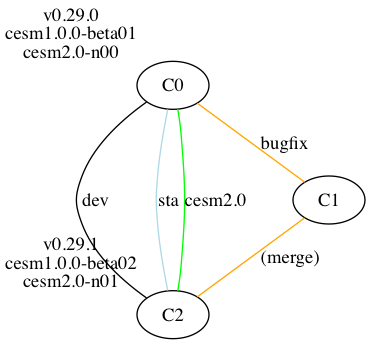

In [3]:
# Add node for new release
C2 = pydot.Node("C2", xlabel="v0.29.1\ncesm1.0.0-beta02\ncesm2.0-n01")
graph.add_node(C2)

# Edges for development, stable, and cesm2.0
edge = pydot.Edge("C0", "C2", label=development["label"], color=development["color"]) # edge for development
graph.add_edge(edge)
edge = pydot.Edge("C0", "C2", label=stable["label"], color=stable["color"]) # edge for stable
graph.add_edge(edge)
edge = pydot.Edge("C0", "C2", label="cesm2.0", color=release_branch["color"]) # edge for cesm2.0
graph.add_edge(edge)

# Edges for bugfix and merge
edge = pydot.Edge("C0", "C1", label="bugfix", color=bugfix_enhancement["color"]) # edge for bugfix
graph.add_edge(edge)
edge = pydot.Edge("C1", "C2", label="(merge)", color=bugfix_enhancement["color"])
graph.add_edge(edge)

# Draw graph
viewPydot(graph)

## Working towards CESM 2.1

Now suppose we are ready to develop something new for CESM 2.1. We create a new branch _enhancement_, and make commits `C3` and `C4` on it, and then merge it back to _development_ with `git merge enhancement --no-ff`, resulting in `C5`. Also, _development_ is merged onto _stable_ with `git merge development --ff-only`, and we create a new branch _cesm2.1_ from this commit. `C5` is tagged as _v0.30.0_, _cesm1.0.0-beta03_, and _cesm2.1-n00_.


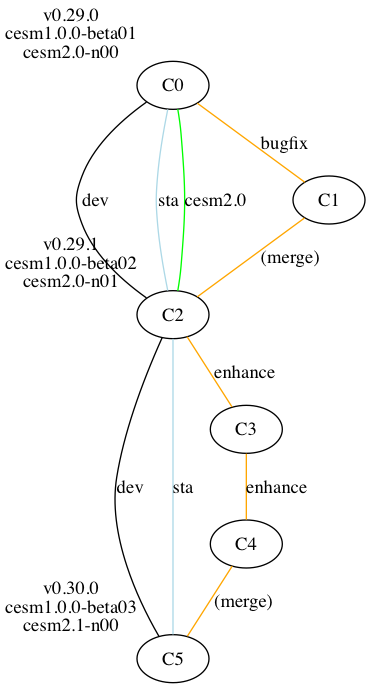

In [4]:
# Add node for new release
C5 = pydot.Node("C5", xlabel="v0.30.0\ncesm1.0.0-beta03\ncesm2.1-n00")
graph.add_node(C5)

# Edges for development and stable
edge = pydot.Edge("C2", "C5", label=development["label"], color=development["color"]) # edge for development
graph.add_edge(edge)
edge = pydot.Edge("C2", "C5", label=stable["label"], color=stable["color"]) # edge for stable
graph.add_edge(edge)

# Edges for enhancement and merge
edge = pydot.Edge("C2", "C3", label="enhance", color=bugfix_enhancement["color"]) # edge for bugfix
graph.add_edge(edge)
edge = pydot.Edge("C3", "C4", label="enhance", color=bugfix_enhancement["color"]) # edge for bugfix
graph.add_edge(edge)
edge = pydot.Edge("C4", "C5", label="(merge)", color=bugfix_enhancement["color"])
graph.add_edge(edge)

# Draw graph
viewPydot(graph)

# Oh no, another bug on cesm2.0 release branch!

At this point, we realize there is a bug in `C2` that we want to fix for _cesm2.0_. So we make the _bugfix2_ branch off of `C2`, make commits `C6` and `C7` to fix the bug, and then merge it back to _cesm2.0_ with `git merge bugfix2 --no-ff`, resulting in `C8`. That commit is tagged _cesm2.0-n02_

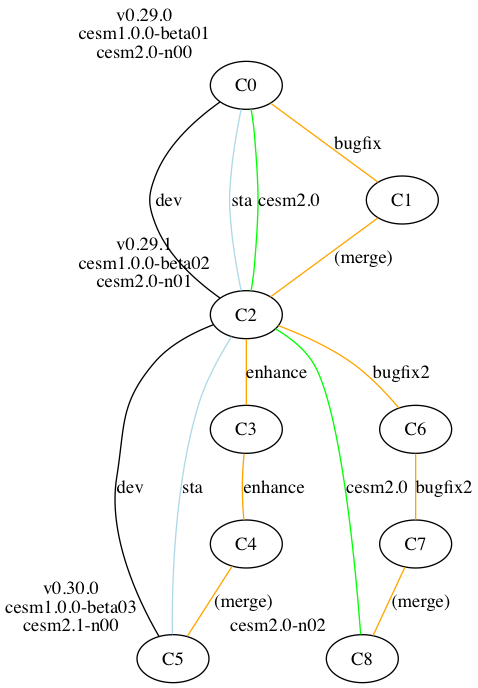

In [5]:
# Add node for new release
C8 = pydot.Node("C8", xlabel="cesm2.0-n02")
graph.add_node(C8)

# Edge for cesm2.0
edge = pydot.Edge("C2", "C8", label="cesm2.0", color=release_branch["color"])
graph.add_edge(edge)

# Edges for bugfix and merge
edge = pydot.Edge("C2", "C6", label="bugfix2", color=bugfix_enhancement["color"]) # edge for bugfix
graph.add_edge(edge)
edge = pydot.Edge("C6", "C7", label="bugfix2", color=bugfix_enhancement["color"]) # edge for bugfix
graph.add_edge(edge)
edge = pydot.Edge("C7", "C8", label="(merge)", color=bugfix_enhancement["color"])
graph.add_edge(edge)

# Draw graph
viewPydot(graph)

### Merging bugfix back to development, stable, and cesm2.1

Now that the bug has been fixed in the oldest release, we merge `C7` back to `development` with `git merge enhancement --no-ff`, resulting in `C9`. Also, _development_ is merged onto _stable_ and _cesm2.1_ with `git merge development --ff-only`, and that commit is labeled _v0.30.1_, _v1.0.0-beta04_, and _cesm2.1-n02_.

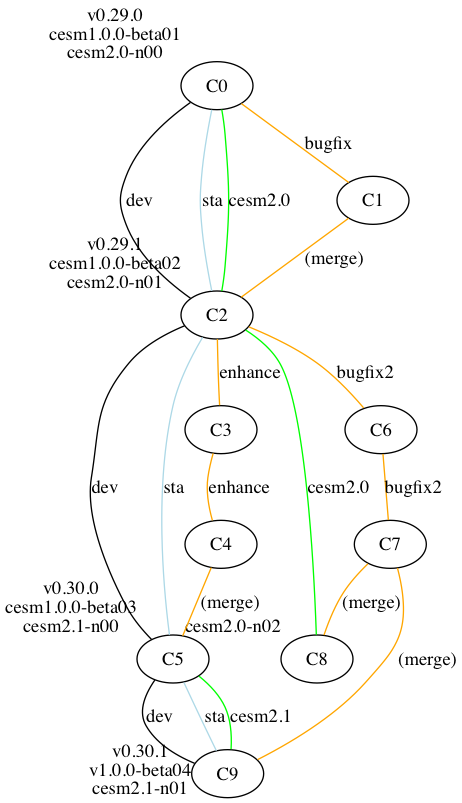

In [6]:
# Add node for new release
C9 = pydot.Node("C9", xlabel="v0.30.1\nv1.0.0-beta04\ncesm2.1-n01")
graph.add_node(C9)

# Edges for development, stable, and cesm2.1
edge = pydot.Edge("C5", "C9", label=development["label"], color=development["color"]) # edge for development
graph.add_edge(edge)
edge = pydot.Edge("C5", "C9", label=stable["label"], color=stable["color"]) # edge for stable
graph.add_edge(edge)
edge = pydot.Edge("C5", "C9", label="cesm2.1", color=release_branch["color"]) # edge for cesm2.0
graph.add_edge(edge)

# Edges for merge
edge = pydot.Edge("C7", "C9", label="(merge)", color=bugfix_enhancement["color"])
graph.add_edge(edge)

# Draw graph
viewPydot(graph)